# Fig. 3: Shape descriptors used to measure phosphene variability

In [1]:
import os
import numpy as np
import pandas as pd

import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-08-04 14:19:17,810 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjects = subjectdata.index.sort_values()

In [3]:
X, y = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'))
Xy = pd.concat((X, y.drop(columns='electrode')), axis=1)

## Fig. 3A-C: Shape descriptors

In [4]:
cols = ['area', 'orientation', 'eccentricity']
ylabels = ['area (pixels)', 'orientation (deg)', 'elongation']

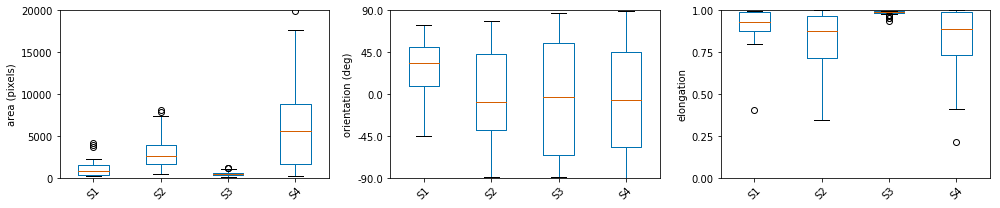

In [5]:
ylimits = [[0, 20000], [-np.pi/2, np.pi/2], [0, 1]]

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim in zip(cols, axes, ylabels, ylimits):
    gb = Xy.loc[:, ['subject', col]].groupby('subject', sort=True)
    gb.boxplot(subplots=False, grid=False, rot=45, ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_xticklabels(subjects)
    if col == 'orientation':
        ax.set_yticklabels(np.linspace(*np.rad2deg(ylim), num=5))
    ax.set_ylabel(ylabel)
fig.tight_layout()
fig.savefig('fig3a-shape-descriptors.eps')

## Fig. 3D-F: Shape variability

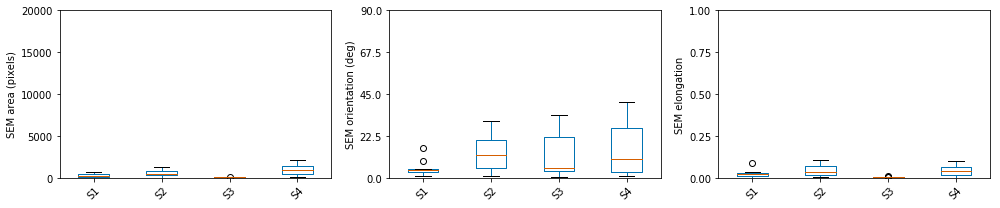

In [6]:
ylimits = [[0, 20000], [0, np.pi/2], [0, 1]]

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim in zip(cols, axes, ylabels, ylimits):
    gb = Xy.loc[:, ['subject', 'electrode', col]].groupby(['subject', 'electrode'], sort=True)
    ggb = gb.sem().groupby('subject')
    ggb.boxplot(subplots=False, grid=False, rot=45, ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    if col == 'orientation':
        ax.set_yticklabels(np.linspace(*np.rad2deg(ylim), num=5))
    ax.set_xticklabels(subjects)
    ax.set_ylabel('SEM %s' % ylabel)
fig.tight_layout()
fig.savefig('fig3b-shape-variability.eps')